- TF-IDF: 텍스트 벡터화
- PCA : 차원 축소
- LSA : 잠재 의미 분석
- t-SNE : 2D시각화
- 로지스틱회귀
- 토큰화 & 전처리

In [27]:
# LSA
# TF-IDF 행렬에 대해서 SVD 를 적용
# 단어와 문서 간의 숨겨진 의미 관계를 찾음
# PCA 차이 
    # PCA : 데이터 자체 분산 최대화
    # LSA : 문서-단어형태의 의미 구조 파악
# "은행"
    # "돈"  "계좌"      주변에 등장
    # "나무" "냄새" "먹는다"    주변에 등장

In [28]:
# t-SNE : 고차원 데이터를 2D/3D로 변환 - 시각화 전용(분석에는 부적합), 계산이 오래걸림
# PCA vs t-SNE
# PCA : 속도가 빠름, 전역 구조 보존
# t-SNE : 느림, 국소(지역) 군집 명확

In [29]:
import re

def clean_text(text):
    # 헤더 제거
    text = re.sub(r'^From:.*\n', '', text, flags=re.MULTILINE)
    text = re.sub(r'^Subject:.*\n', '', text, flags=re.MULTILINE)

    # 풋터 제거
    text = re.sub(r'\n--\n.*$', '', text, flags=re.DOTALL)

    # 인용문 제거
    text = re.sub(r'(^|\n)[>|:].*', '', text)

    return text

In [30]:
# 데이터셋
from sklearn.datasets import fetch_20newsgroups
categories =  ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# data load
newsgroups_train = fetch_20newsgroups(subset='train'
                    ,remove = ('headers','footers','quotes')
                    ,categories=categories
)
newsgroups_test = fetch_20newsgroups(subset='test'
                    ,remove = ('headers','footers','quotes')
                    ,categories=categories
)

# 카테고리 제거
def filter_categories(dataset, categories):
    target_names = dataset.target_names
    selected_idx = [ target_names.index(c) for c in categories  ]
    #필터링
    data_filtered, target_filtered = [], []
    for text,label in zip(dataset.data, dataset.target):
        if label in selected_idx:
            new_label = selected_idx.index(label)  # 라벨 재 정렬
            data_filtered.append(text) ; target_filtered.append( new_label )
    return data_filtered,target_filtered,categories

train_data, train_target, target_names = filter_categories(newsgroups_train,categories)
test_data, test_target, _ = filter_categories(newsgroups_test,categories)

x_train = [ clean_text(t) for t in train_data]
x_test = [ clean_text(t) for t in test_data]
y_train = train_target
y_test = test_target

In [31]:
# 텍스트 전처리 ( 소문자 + 토큰화(3글자이상) + 불용어제거(stopwords) + 어간추출(stemming))  --> 영어
# 파이프라인 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer  # 같은 의미의 다른형태 단어를 통일
from sklearn.feature_extraction.text import TfidfVectorizer
regtok = RegexpTokenizer(r"[\w']{3,}")
english_stops = set(stopwords.words('english'))
# 커스텀 토크나이져
def tokenizer(text):
    tokens = regtok.tokenize(text)
    words = [word for word in tokens if word not in english_stops]
    features = list(map(lambda x : PorterStemmer().stem(x), words))
    return features
# TF-IDF 벡터화
tfidf = TfidfVectorizer(tokenizer=tokenizer,max_features=2000,min_df=2,max_df=0.5)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)
# 분류모델
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=200,random_state=42)
lr_clf.fit(x_train_tfidf,y_train)

print('기본분류------------')
print(f'학습정확도 : {lr_clf.score(x_train_tfidf,y_train)}')
print(f'테스트정확도 : {lr_clf.score(x_test_tfidf,y_test)}')

print('주성분분석')
# 데이터의 분산이 가장 큰 방향
# 선형번환만 가능
# 모든 데이터의 특성을 평등하게 고려
# 용도 : 시각화, 속도 개선
# 2000차원 - >100차원축소
from sklearn.decomposition import PCA
pca = PCA(n_components=100,random_state=42)
x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
x_test_pca = pca.transform(x_test_tfidf.toarray())

import numpy as np
cumsum_var =  np.cumsum( pca.explained_variance_ratio_)
print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소후 차원 : {x_train_pca.shape[1]}')
print(f'설명된 분산 : {pca.explained_variance_.sum()}')
print(f'누적 분산 : {cumsum_var[:10]}')

# pca 후 분류
lr_clf_pca = LogisticRegression(max_iter=200,random_state=42)
lr_clf_pca.fit(x_train_pca,y_train)

print('주성분 분석 분류------------')
print(f'학습정확도 : {lr_clf_pca.score(x_train_pca,y_train)}')
print(f'테스트정확도 : {lr_clf_pca.score(x_test_pca,y_test)}')

c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


기본분류------------
학습정확도 : 0.9193706981317601
테스트정확도 : 0.7420546932742055
주성분분석
원본 차원 : 2000
축소후 차원 : 100
설명된 분산 : 0.27475480194078783
누적 분산 : [0.0119533  0.02039927 0.02724907 0.03330996 0.03885003 0.04385968
 0.04879366 0.05360963 0.05821674 0.06259882]
주성분 분석 분류------------
학습정확도 : 0.8028515240904621
테스트정확도 : 0.7309682187730968


In [32]:
# lsa  잠재적 의미분석
# tf-idf svd
# PCA보다 의미론적 관계 잘 포착
# 테스트 데이터에 효과적
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100,random_state=42)
x_train_lsa = svd.fit_transform(x_train_tfidf)
x_test_lsa = svd.transform(x_test_tfidf)

print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소후 차원 : {x_train_lsa.shape[1]}')
print(f'설명된 분산 : {svd.explained_variance_.sum()}')

# lsa 후 분류
lr_clf_lsa = LogisticRegression(max_iter=200,random_state=42)
lr_clf_lsa.fit(x_train_lsa,y_train)

print('주성분 분석 분류------------')
print(f'학습정확도 : {lr_clf_lsa.score(x_train_lsa,y_train)}')
print(f'테스트정확도 : {lr_clf_lsa.score(x_test_lsa,y_test)}')

원본 차원 : 2000
축소후 차원 : 100
설명된 분산 : 0.2729338330142783
주성분 분석 분류------------
학습정확도 : 0.8008849557522124
테스트정확도 : 0.7331855136733185


In [33]:
# LSA 기반 유사도 분석
# 코사인 유사도  0(완전히 다름) ~ 1(같음)
# LSA 의미기반 유사도
# 첫번재 문서의 유사 문서 찾기
from sklearn.metrics.pairwise import cosine_similarity
sim_result = cosine_similarity([x_train_lsa[0]], x_train_lsa)
sim_index = (-sim_result[0]).argsort()[:20]
print(f'원문 카테고리 :{newsgroups_train.target_names[y_train[0]]}')
print(f'상위 유사도 : {sorted(sim_result[0],reverse=True)[:5]}')
similar_categorys =  [newsgroups_train.target_names[y_train[i]] for i in sim_index]
print(f'유사 문서들의 카테고리 : {similar_categorys[:10]}')

원문 카테고리 :sci.space
상위 유사도 : [np.float64(1.0), np.float64(0.7866101310807626), np.float64(0.7847117123209297), np.float64(0.7702419626222283), np.float64(0.7438231959345433)]
유사 문서들의 카테고리 : ['sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space']


In [34]:
# t-sne  2D 시각화
# 고차원 데이터를 2D/3D 변환
# 비슷한 데이터는 가깝게 다른데이터는 멀리 배치
# 계산이 오래 걸리지만 시각화 효과 가 뛰어남
# 주의 : 분석용이 아니라 시각화 전용
from sklearn.manifold import TSNE
# perplexity 이웃개수 조절 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tnse_lsa = tsne.fit_transform(x_train_lsa)
print(f'입력 차원 : {x_train_lsa.shape[1]}')
print(f'출력 차원 : {tnse_lsa.shape}')

입력 차원 : 100
출력 차원 : (2034, 2)


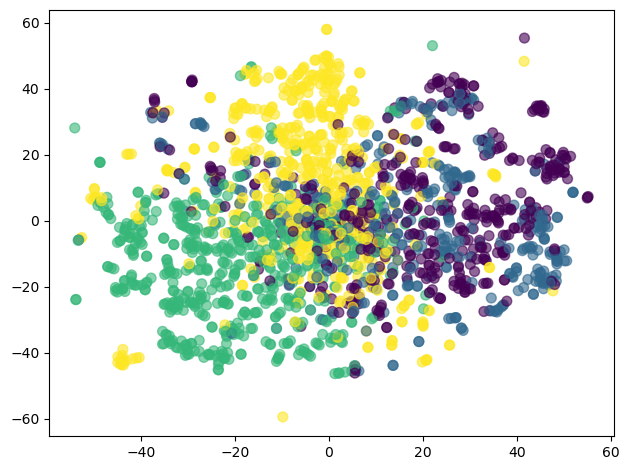

In [35]:
import matplotlib.pyplot as plt
colors = y_train[:len(tnse_lsa)]
plt.scatter(tnse_lsa[:,0],tnse_lsa[:,1],c = colors, cmap='viridis',alpha=0.6,s=50)
plt.tight_layout()
plt.show()

In [36]:
# TF-IDF(원본 데이터)
    # 장점 : 해석이 쉽고 정확도가 높은
    # 단점 : 메모리 많이 사용(차원이 높음->차원의 저주)
    # 용도 : 정확도가 우선일때
# PCA(선형 차원 축소)
    # 장점 : 계산이 빠르고 간단, 분산 최대 보존
    # 단점 : 선형 변환만 가능
    # 용도 : 속도와 정확도 균형
# LSA(의미 기반 차원 축소)
    # 장점 : 의미관계 잘 포착, 유사도 계산에 효과적
    # 단점 : 계산비용 중간
    # 용도 : 문서 유사도, 추천시스템
# t-SNE(비선형 시각화)
    # 장점 : 군집구조 명확히 보임
    # 단점 : 계산이 오래 걸림, 분석용이 아닌 시각화
    # 용도 : 데이터 탐색 및 이해

In [37]:
# 한국어 데이터
import pandas as pd
url = "https://drive.google.com/uc?id=1KOKgZ4qCg49bgj1QNTwk1Vd29soeB27o"
df = pd.read_csv(url)

In [38]:
# 데이터(문장)
# 문장 ->벡터
    # 문장 -> 토큰화
        # 다양한 토크나이져
            # 한글 Okt
                # Okt().pos(문장)
                # 불용어 제거 - 불용어 리스트를 만들어서 stopword 하듯이 제거
    # 토큰 - > 벡터화
        # BoW(CounterVectorizer)
        # TF-IDF
# 분류모델 선택
# 학습
# 평가